In [4]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/analysis/'

### recupero info su dimensionalità
spectra_path = '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 101x83, per un totale di 8383 spettri


In [5]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)


for (ii,jj) in boni:
    matrix[ii][jj].Recover_VIPA(x_VIPA, y_VIPA)


count = 0
for (ii,jj) in serpentine_range(n_rows, n_cols, 'right'):
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [6]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


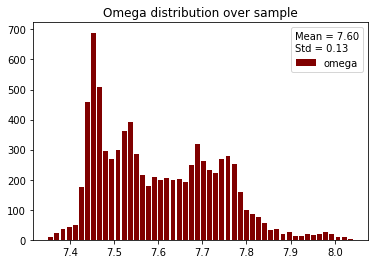

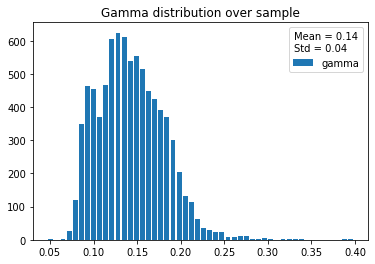

In [37]:
#HISTOGRAMs - MARKOV
markov_Omegas = np.array([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
markov_Gammas =  np.array([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])


plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist(markov_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Omegas), np.std(markov_Omegas)))
plt.savefig(now_path+'Omega_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist(markov_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Gammas), np.std(markov_Gammas)))
plt.savefig(now_path+'Gamma_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [39]:
#Parametri di Interesse per analisi
markov_too_bad = ()
markov_too_good  = ()
markov_omega_too_high =  ()
markov_gamma_too_bad = ()

markov_omega_max = np.mean(markov_Omegas)+5*np.std(markov_Omegas)
markov_gamma_max = np.mean(markov_Gammas)+5*np.std(markov_Gammas)
cost_max = 1000
cost_min = 50


markov_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'markov')
markov_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'markov')
markov_omega_too_high = Whose_Param_Too_High('Omega', markov_omega_max, 'markov', matrix, boni)
markov_gamma_too_high = Whose_Param_Too_High('Gamma', markov_gamma_max, 'markov', matrix, boni)


#aggiunte 
markov_too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        markov_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        markov_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        markov_almost_height += ((ii,jj),)


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(markov_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(markov_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(markov_omega_too_high), markov_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(markov_gamma_too_high), markov_gamma_max))

print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(too_offset), max_offset))





I found 0 bad elements out of 8317

I found 6369 good elements out of 8317

(68, 24) ha Gamma= 0.39
(69, 66) ha Gamma= 0.34
(69, 68) ha Gamma= 0.34
(70, 45) ha Gamma= 0.38
(71, 24) ha Gamma= 0.39
(78, 26) ha Gamma= 0.40
(82, 35) ha Gamma= 0.33




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis/ :

0 elementi con chi quadro > 1000 
6369 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.26
7 elementi con Gamma > Gamma max 0.33

1314 elementi con Gamma con errore percentuale > 15 

0 elementi con offset > 30 



(68, 24)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.157912  7.560249  0.392178        1.528953     0.000106   
StdErrs        NaN       NaN       NaN             NaN          NaN   
Initials  0.150049  7.629575  0.282345        0.213811     0.004171   

          delta_amplitude           A        mu      sigma     shift  \
Values           0.057461  201.033461 -5.993616  14.888522  0.268690   
StdErrs               NaN         NaN       NaN        NaN       NaN   
Initials         1.216826  187.770805 -6.054158  14.903426  0.032224   

             offset  
Values    52.399559  
StdErrs         NaN  
Initials  58.041157  


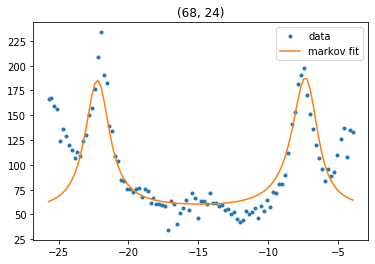

(69, 66)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.155151  7.521975  0.335700        0.213935     0.002859   
StdErrs   0.154592  0.049080  0.028880        0.000170     0.002219   
Initials  0.118775  7.605336  0.218497        0.213865     0.000825   

          delta_amplitude             A         mu      sigma     shift  \
Values           4.228721  1.175834e+03  -5.935072  14.986941  0.060031   
StdErrs          4.293993  1.955654e+09  24.744149  20.064032  0.033075   
Initials        13.916900  9.840967e+02  -5.995022  15.001943  0.256750   

             offset  
Values    61.160773  
StdErrs    1.912274  
Initials  35.307747  


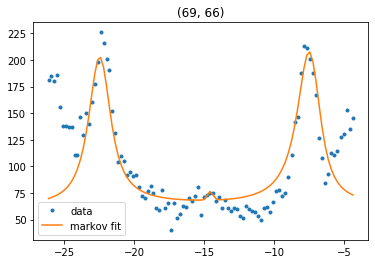

(69, 68)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.153932  7.464931  0.339142        0.213875     0.003521   
StdErrs   0.142454  0.048936  0.031878        0.000147     0.001689   
Initials  0.155151  7.521975  0.335700        0.213935     0.002859   

          delta_amplitude             A         mu      sigma     shift  \
Values           5.608797  9.406674e+02  -5.875721  14.971954  0.050081   
StdErrs          3.259287  1.521599e+09  23.219795  18.738668  0.029506   
Initials         4.228721  1.175834e+03  -5.935072  14.986941  0.060031   

             offset  
Values    48.281661  
StdErrs    1.907253  
Initials  61.160773  


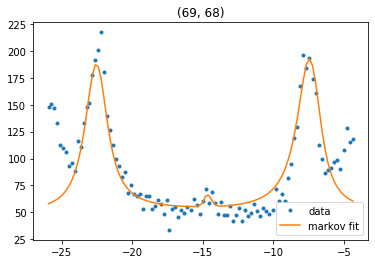

(70, 45)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.183988  7.619275  0.383991        0.214025     0.003607   
StdErrs   0.141160  0.049145  0.028835        0.000100     0.001251   
Initials  0.125799  7.692631  0.208575        0.213940     0.003842   

          delta_amplitude             A         mu      sigma     shift  \
Values           8.075498  2.206768e+03  -5.969994  15.067994  0.210558   
StdErrs          3.773832  3.587405e+09  19.437797  15.655861  0.031626   
Initials         2.559202  2.758460e+03  -6.030297  15.083077  0.201749   

             offset  
Values    50.886517  
StdErrs    2.140070  
Initials  28.450752  


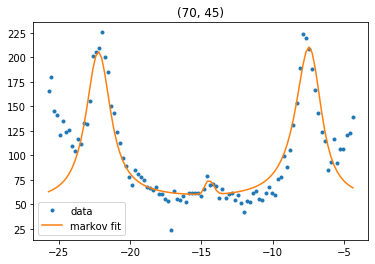

(71, 24)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.163296  7.710875  0.389355        0.213982     0.001280   
StdErrs   0.140229  0.055730  0.031976        0.023772     2.691292   
Initials  0.131910  7.790250  0.270911        0.213998     0.001226   

          delta_amplitude             A         mu      sigma     shift  \
Values          24.248199  4.571067e+02  -5.942113  14.846669  0.201495   
StdErrs     228955.173161  6.850006e+08  20.939132  16.592356  0.032573   
Initials        30.925915  3.824362e+02  -6.002134  14.861531  0.196637   

             offset  
Values    54.203898  
StdErrs    2.113597  
Initials  33.895518  


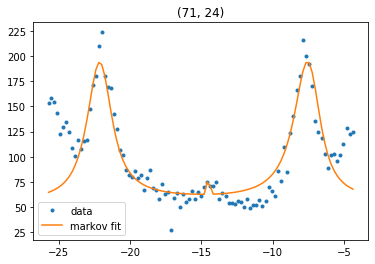

(78, 26)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.167054  7.474464  0.397992        0.213968     0.004092   
StdErrs   0.138054  0.058793  0.033916        0.000325     0.003802   
Initials  0.139174  7.713748  0.278645        0.214087     0.001876   

          delta_amplitude             A         mu      sigma     shift  \
Values           2.909121  2.260417e+02  -5.989420  14.858179 -0.026818   
StdErrs          3.470794  3.959968e+08  20.063381  16.399117  0.035191   
Initials         2.891121  1.885921e+02  -6.049919  14.873052  0.016923   

             offset  
Values    60.928092  
StdErrs    2.380060  
Initials  51.178805  


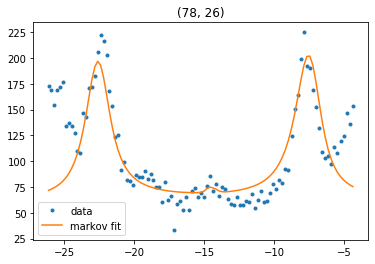

(82, 35)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.162903  7.655361  0.330801        0.214110     0.003486   
StdErrs   0.156700  0.044532  0.027934        0.000137     0.001662   
Initials  0.133894  7.677578  0.253320        0.214142     0.001234   

          delta_amplitude             A         mu      sigma     shift  \
Values           5.950455  1.012842e+02  -5.830596  14.858792 -0.001894   
StdErrs          3.933482  1.709401e+08  23.306617  18.631824  0.028876   
Initials        11.635205  8.454443e+01  -5.889491  14.873666  0.217405   

             offset  
Values    58.517578  
StdErrs    1.933366  
Initials  42.028544  


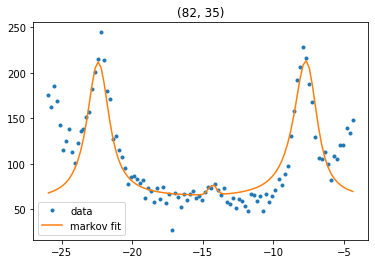

In [40]:
Plot_Elements_Spectrum(matrix, markov_gamma_too_high, fit = 'markov')

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


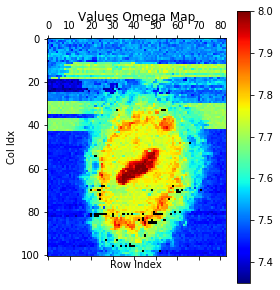

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


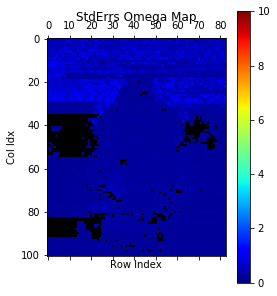

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


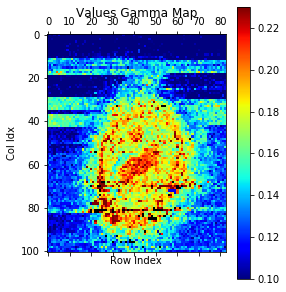

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


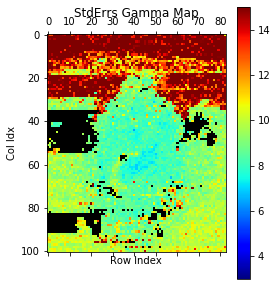

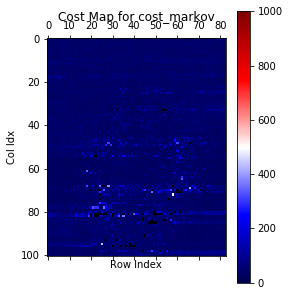

In [9]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.23, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

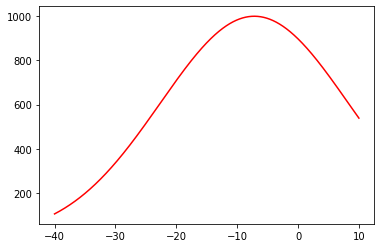

,mu,sigma
Values,-7.184732,15.447074
StdErrs,31.913324,30.506826
Initials,-7.113596,15.431642


In [12]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


In [13]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


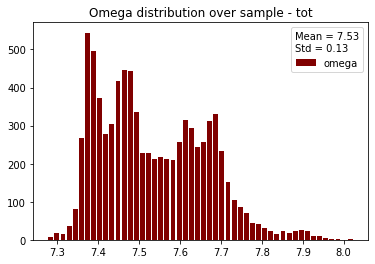

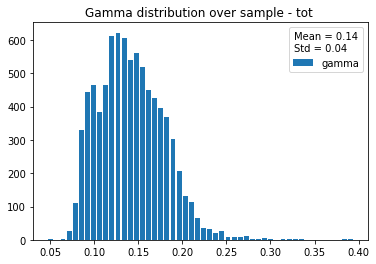

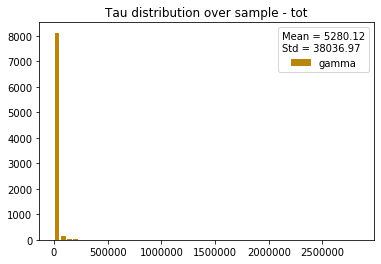

In [42]:
#HISTOGRAMs
tot_Omegas = np.array([matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
tot_Gammas =  np.array([matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])
taus       = np.array([matrix[ii][jj].Tot_Fit_Params['tau'].values[0] for (ii,jj) in boni])

plt.figure()
plt.title('Omega distribution over sample - tot')
_ = plt.hist(tot_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Omegas), np.std(tot_Omegas)))
plt.savefig(now_path+'Omega_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample - tot ')
_ = plt.hist(tot_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Gammas), np.std(tot_Gammas)))
plt.savefig(now_path+'Gamma_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Tau distribution over sample - tot')
_ = plt.hist(taus, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8, color = 'darkgoldenrod')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(taus), np.std(taus)))
plt.savefig(now_path+'tau_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [53]:
#Parametri di Interesse per analisi
tot_too_bad = ()
tot_too_good  = ()
tot_omega_too_high =  ()
tot_gamma_too_bad = ()
tau_not_bad = []

tot_omega_max = np.mean(tot_Omegas)+5*np.std(tot_Omegas)
tot_gamma_max = np.mean(tot_Gammas)+5*np.std(tot_Gammas)
cost_max = 1000
cost_min = 50


tot_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'tot')
tot_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'tot')
tot_omega_too_high = Whose_Param_Too_High('Omega', tot_omega_max, 'markov', matrix, boni)
tot_gamma_too_high = Whose_Param_Too_High('Gamma', tot_gamma_max, 'markov', matrix, boni)


#aggiunte 
omega_different_from_mark = []
gamma_different_from_mark = []

percentage_diff = 0.8
tot_too_offset = ()
percentage_gamma = 100
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    
    perc_omega = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100
    perc_gamma = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100

    if (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] > matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] < matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] - perc_gamma):
        omega_different_from_mark.append((ii,jj))
    if (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] > matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] < matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] - perc_omega):
        gamma_different_from_mark.append((ii,jj))
    if matrix[ii][jj].Tot_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Tot_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        tot_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['offset'].values[0] > max_offset:
        tot_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        tot_almost_height += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(tot_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(tot_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(tot_omega_too_high), tot_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(tot_gamma_too_high), tot_gamma_max))


print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(too_offset), max_offset))

print('{} elementi il cui fit tot di Omega è diverso del {} percento da markoviano'.format(len(omega_different_from_mark), percentage_diff))
print('{} elementi il cui fit tot di Gamma è diverso del {} percento da markoviano'.format(len(gamma_different_from_mark), percentage_diff))
print('{} elementi il cui fit di tau non è cosi male..'.format(len(tau_not_bad)), tau_not_bad)


I found 9 bad elements out of 8317

I found 3572 good elements out of 8317

(68, 24) ha Gamma= 0.39
(69, 66) ha Gamma= 0.34
(69, 68) ha Gamma= 0.34
(70, 45) ha Gamma= 0.38
(71, 24) ha Gamma= 0.39
(78, 26) ha Gamma= 0.40
(82, 35) ha Gamma= 0.33




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis/ :

9 elementi con chi quadro > 1000 
3572 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.18
7 elementi con Gamma > Gamma max 0.33

1314 elementi con Gamma con errore percentuale > 100 

0 elementi con offset > 30 

6851 elementi il cui fit tot di Omega è diverso del 0.8 percento da markoviano
0 elementi il cui fit tot di Gamma è diverso del 0.8 percento da markoviano
4 elementi il cui fit di tau non è cosi male.. [(40, 76), (55, 35), (56, 37), (73, 52)]


(40, 76)
                Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.121118  7.597234  0.140535  46.504229  0.352776       -1.306459   
StdErrs   0.006732  0.101374  0.136881   7.005520  0.055209        0.049083   
Initials  0.100932  7.673974  0.139143   0.139143  1.000000        1.497096   

          delta_width  delta_amplitude     shift     offset  
Values       1.927876         0.003110  3.178711 -29.951370  
StdErrs      0.024070         0.000049  0.049086   1.976993  
Initials     1.947349         0.003079  0.370169   9.345889  


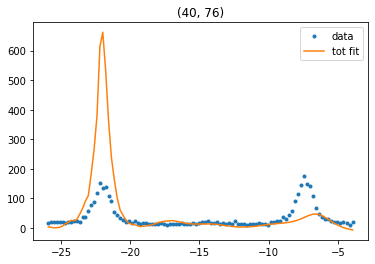

(55, 35)
                Co     Omega     Gamma     Delta       tau  delta_position  \
Values    0.126977  7.841040  0.151596  1.329075  0.187231       -0.953126   
StdErrs   0.016183  0.533183  0.193697  1.079040  0.149536        0.024172   
Initials  0.105826  7.764344  0.152495  0.152495  1.000000       -1.092358   

          delta_width  delta_amplitude     shift      offset  
Values       2.285461         0.000448  0.101128 -101.234881  
StdErrs      0.005380         0.000002  0.024172    2.108611  
Initials     2.308546         0.000443  0.240191    7.533263  


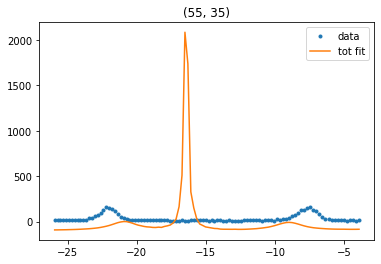

(56, 37)
                Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.122793  7.852515  0.150517  48.034950  2.992578       -1.992852   
StdErrs   0.003141  0.210306  0.042498  47.716383  2.831134        0.007243   
Initials  0.102327  7.774768  0.149228   0.149228  1.000000       -1.999833   

          delta_width  delta_amplitude     shift      offset  
Values       0.979882         0.000549  0.223549 -229.246867  
StdErrs      0.000746         0.000002  0.007243    0.799971  
Initials     0.989780         0.000554  0.230493    6.482707  


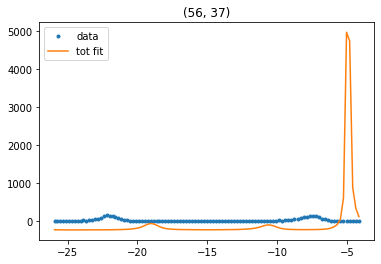

(73, 52)
                Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.122358  7.744938  0.177469  27.212238  0.156088        1.276562   
StdErrs   0.011103  0.751821  0.709926   4.589721  0.039931        0.296267   
Initials  0.101965  7.823169  0.175712   0.175712  1.000000        1.277469   

          delta_width  delta_amplitude     shift     offset  
Values       1.902392         0.001092  0.179457 -25.434519  
StdErrs      0.013211         0.000011  0.296266   2.212894  
Initials     1.921608         0.001081  0.175201   8.549241  


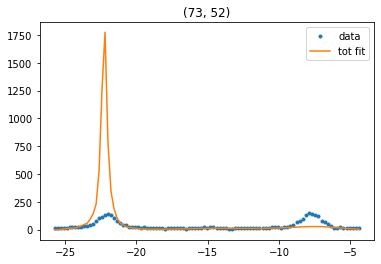

In [54]:
Plot_Elements_Spectrum(matrix, tau_not_bad[:10], fit = 'tot')

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


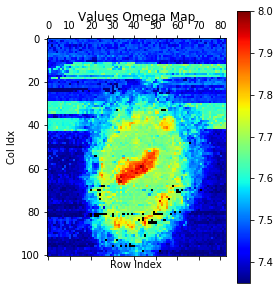

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


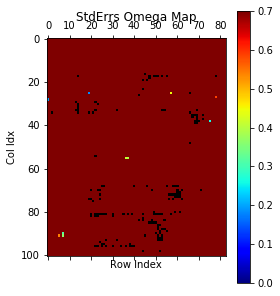

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


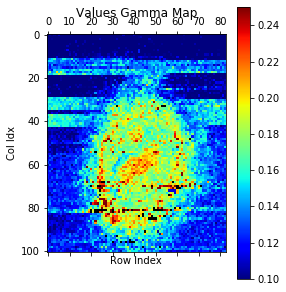

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


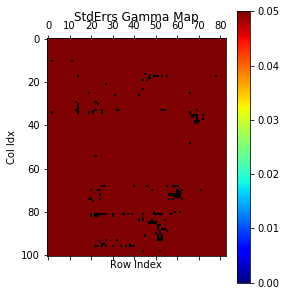

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


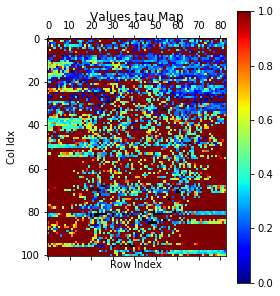

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


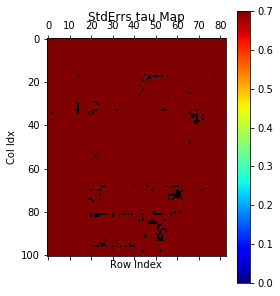

In [14]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 1., fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

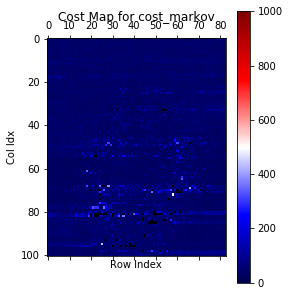

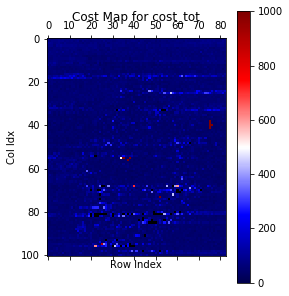

In [15]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


In [17]:
tau_not_bad = []
for (ii,jj) in boni:
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))
        print(str((ii,jj)))
        

(40, 76)
(55, 35)
(56, 37)
(73, 52)


In [18]:
for (ii,jj) in tau_not_bad:
    print(str((ii,jj)), '\n', matrix[ii][jj].Tot_Fit_Params)

(40, 76) 
                 Co     Omega     Gamma      Delta       tau  delta_position  \
Values    0.121118  7.597234  0.140535  46.504229  0.352776       -1.306459   
StdErrs   0.006732  0.101374  0.136881   7.005520  0.055209        0.049083   
Initials  0.100932  7.673974  0.139143   0.139143  1.000000        1.497096   

          delta_width  delta_amplitude     shift     offset  
Values       1.927876         0.003110  3.178711 -29.951370  
StdErrs      0.024070         0.000049  0.049086   1.976993  
Initials     1.947349         0.003079  0.370169   9.345889  
(55, 35) 
                 Co     Omega     Gamma     Delta       tau  delta_position  \
Values    0.126977  7.841040  0.151596  1.329075  0.187231       -0.953126   
StdErrs   0.016183  0.533183  0.193697  1.079040  0.149536        0.024172   
Initials  0.105826  7.764344  0.152495  0.152495  1.000000       -1.092358   

          delta_width  delta_amplitude     shift      offset  
Values       2.285461         0.00044

In [19]:
matrix[73][52].Tot_Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.122358,7.744938,0.177469,27.212238,0.156088,1.276562,1.902392,0.001092,0.179457,-25.434519
StdErrs,0.011103,0.751821,0.709926,4.589721,0.039931,0.296267,0.013211,0.000011,0.296266,2.212894
Initials,0.101965,7.823169,0.175712,0.175712,1.000000,1.277469,1.921608,0.001081,0.175201,8.549241


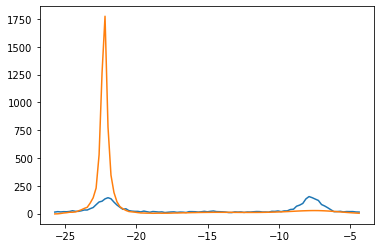

In [48]:
plot(matrix[73][52].x_freq, matrix[73][52].y)
plot(matrix[73][52].x_freq, matrix[73][52].y_fit)

In [21]:
matrix[73][52].Tot_Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_position,delta_width,delta_amplitude,shift,offset
Values,0.122358,7.744938,0.177469,27.212238,0.156088,1.276562,1.902392,0.001092,0.179457,-25.434519
StdErrs,0.011103,0.751821,0.709926,4.589721,0.039931,0.296267,0.013211,0.000011,0.296266,2.212894
Initials,0.101965,7.823169,0.175712,0.175712,1.000000,1.277469,1.921608,0.001081,0.175201,8.549241
